In [1]:
import sys

import pylibxc
import numpy as np
import matplotlib.pyplot as plt

def get_density(r_s):
  return 3/(4*np.pi*(r_s ** 3))

def hartree_to_mRy(energy):
  return energy * 2 * 1000

def get_eps_x_unif(n):
  return -(3/(4*np.pi))*((n*3*np.pi**2)**(1/3))

def get_grad_n(s, n):
  return s*((n**(4/3))*2*(3*np.pi**2)**(1/3))

def get_up_dn_density(n, zeta):
  n = np.expand_dims(n.flatten(), axis=1)
  zeta = np.expand_dims(zeta.flatten(), axis=1)

  up_density = ((zeta * n) + n)/2
  dn_density = (n - (zeta * n))/2
  return np.concatenate((up_density, dn_density), axis=1)

def get_tau(alpha, grad_n, n):
  tau_w = (grad_n**2) / (8*n)
  tau_unif = (3/10)*((3*np.pi)**(2/3))*(n**(5/3))
  
  return alpha*tau_unif +tau_w

eps_x = eps_c = 'zk'

In [31]:
# pol. SCAN
scan_x = pylibxc.LibXCFunctional("mgga_x_scan", "polarized")
scan_c = pylibxc.LibXCFunctional("mgga_c_scan", "polarized")

#alpha = np.array([0.01, 1, 1000])
alpha = np.linspace(0.01, 100, num=500)

#r_s = np.array([0.01, 0.05, 2, 10, 1000])
#r_s = np.array([1000])
r_s = np.linspace(0.1, 100, num=500)

s = np.linspace(0, 5)

zeta = np.array([0])

m_r_s, m_zeta, m_s, m_alpha = np.meshgrid(r_s, zeta, s, alpha, indexing='ij')

m_n = get_density(m_r_s)
m_grad_n = get_grad_n(m_s, m_n)
m_eps_x_unif = get_eps_x_unif(m_n)
m_n_spin = get_up_dn_density(m_n, m_zeta)
m_tau = get_tau(m_alpha, m_grad_n, m_n)

# create input
inp = {}

# density
inp["rho"] = m_n_spin

# (| \nabla n |^2, 0, 0) to follow libxc convention
sigma = np.expand_dims(m_grad_n.flatten()**2, axis=1)
#sigma = np.concatenate((sigma, np.zeros_like(sigma), np.zeros_like(sigma)), axis=1)
sigma = np.concatenate((sigma/4, sigma/4, sigma/4), axis=1)
inp["sigma"] = sigma


tau = np.expand_dims(m_tau.flatten(), axis=1)
#tau = np.concatenate((tau, np.zeros_like(tau)), axis=1)
tau = np.concatenate((tau/2, tau/2), axis=1)
inp["tau"] = tau

In [32]:
# results in a.u.
scan_x_res = scan_x.compute(inp)
scan_c_res = scan_c.compute(inp)

In [33]:
# processing 

scan_x_res[eps_x] = np.squeeze(scan_x_res[eps_x])
scan_c_res[eps_c] = np.squeeze(scan_c_res[eps_c])

scan_xc_res = scan_c_res[eps_c] #+ scan_x_res[eps_x]
scan_xc_res = scan_xc_res.reshape(m_r_s.shape)

# F_xc
scan_xc_res /= m_eps_x_unif

In [34]:
# check all results
# F_c(r_s', ...) > F_c(r_s, ...) for r_s' > r_s

min_diff = np.amin(np.diff(scan_xc_res, axis=0))
print('min_diff = ', min_diff)

# if min_diff > 0, then condition is satisified

min_diff =  5.1163351005689695e-05


(0.0, 5.0)

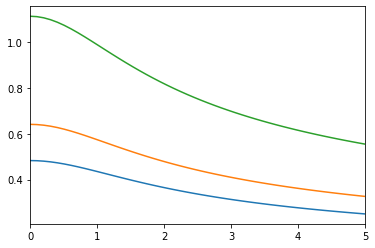

In [10]:
# plotting
# permute axes for plots
perm = [0, 1]

m_s = np.squeeze(m_s)
scan_xc_res = np.squeeze(scan_xc_res)

plt.plot(np.transpose(m_s, perm), np.transpose(scan_xc_res, perm))

#plt.ylim(1, 1.2)
plt.xlim(0, 5)